# LCPB 20-21 exercise 3

### Saverio Monaco

### Gerardo Carmona

### Hilario Capettini

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras import initializers,regularizers

In [2]:
#def data_import(str0):
def data_import(fnamex,fnamey):
    #fnamex ="DATA/x_" + str0 + ".csv"
    #fnamey ="DATA/y_" + str0 + ".csv"

    x = np.loadtxt(fnamex,delimiter=',',dtype=float)
    N = len(x)
    print('Length of x = ',N)



    categ = np.loadtxt(fnamey,delimiter=',', dtype=int)
    #Number of categories
    N_categ = len(np.unique(categ))
    y = np.zeros((N,N_categ))

    for n in range(N):
        y[n][categ[n]] = 1
     
    
    return x,y,N
    

def set_spliting(N,x,y,perc_train = 0.8):  
    N_train = int(N * perc_train)
    N_val = N-N_train

    x_train = x[:N_train]
    y_train = y[:N_train]

    x_val = x[N_train:]
    y_val = y[N_train:]
    
    L =len(x[0])
    
    
    x_train = x_train.reshape(x_train.shape[0],L,1)
    x_val = x_val.reshape(x_val.shape[0],L,1)
    input_shape = (L,1)

    return x_train, y_train, x_val, y_val, input_shape
    
def data_process(x,N):
    xm = x.mean(axis=1)
    for n in range(N):
        x[n] = x[n]-xm[n]
    
    std = x.std(axis=1)
    for n in range(N):
        x[n] = x[n] / std[n]
    return x

def build_model(first_layer,deep_layers,output_size,output_activation = 'softmax', opt = optimizers.Adam()):
    model = Sequential()
    model.add(first_layer)
    for layer in layers: model.add(layer)
    model.add(Dense(output_size,activation = output_activation))
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

    return model


In [3]:
def plot_confusionmatrix(y_pred, y_true, normalization = False):
    # Insted of having y = [0,0,1] , [0,1,0] and [1,0,0] as labels, we transform them in
    # y = 0, 1 ,2
    y_true_mod = np.argmax(y_true, axis=1) #tells wich of the 3 argument is max
    # same for the prediction
    y_pred_mod = np.argmax(y_pred, axis=1)
    # N.B: if we don't do that we get the following error: 
    # ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets
    conf_mat = confusion_matrix(y_pred_mod, y_true_mod) # doing the same makes sense, we take the argument
                                                        # with the highest value (i.e more probable)
    if normalization:
        norm = np.sum(np.sum(conf_mat,axis=1))
        conf_mat = conf_mat / norm
        #print(norm)
        # check that it is normalized
        #print(np.sum(np.sum(conf_mat,axis=0)))
    fig, ax = plt.subplots(figsize=(10,10))
    if not normalization:
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap = "mako")
    if normalization:
        sns.heatmap(conf_mat, annot=True, fmt='f', cmap = "mako")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_accuracyloss(fit, title = False):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    axs = [ax1,ax2]
    obs = ['accuracy','loss']
    for i in range(2):
        axs[i].plot(fit.history[obs[i]],'r',label =obs[i]+' of training data')
        #dashed line!!
        axs[i].plot(fit.history['val_'+obs[i]],'b--',
            label =obs[i]+' of validation data')
        axs[i].set_ylabel(obs[i])
        axs[i].set_xlabel('epochs')
        if title:
            axs[i].set_title(title)
        axs[i].legend()

In [ ]:
#File importation
x, y, N = data_import("DATA/x_ts_L60_Z12_A500_DX50_bias5_N10000.csv",
                      "DATA/y_ts_L60_Z12_A500_DX50_bias5_N10000.csv")
x = data_process(x,N)
x_train, y_train, x_val, y_val, input_shape = set_spliting(N,x,y)

In [ ]:
#Data visualization
plt.title('Examples of Input signals')
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

In [ ]:
reg = regularizers.l1(0.01)    
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
conv_lay = lambda shape: Conv1D(filters =5, kernel_size =11, kernel_regularizer = reg, kernel_initializer = ini, activation = 'relu', input_shape = shape)

layers = [
    AveragePooling1D(5),
    Conv1D(filters=5,kernel_size=7,activation="relu"),
    Flatten(),
    Dense(10,activation='relu'),
    Dropout(0.2)]


model = build_model(conv_lay(input_shape), layers, 3)

print(model.summary())


In [ ]:
batch_size =250
epochs = 10

fit = model.fit(x_train,y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x_val,y_val),
               verbose=2, shuffle=True)

In [ ]:
results = model.predict(x_train)
plot_confusionmatrix(results,y_train, normalization = True)

In [ ]:

plot_accuracyloss(fit)

## 2 
By reducing the signal-to-noise ratio, namely the
amplitude of the external signal in the data (A) with
respect to the step typical size DX of the jump process,
check where the network (defined in the class) starts to
fail discriminating the categories.


In [ ]:
x1,y1,N1 = data_import("DATA/x_ts_L60_Z12_A10_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A10_DX50_bias5_N10000.csv")
x2,y2,N2 = data_import("DATA/x_ts_L60_Z12_A100_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A100_DX50_bias5_N10000.csv")
x3,y3,N3 = data_import("DATA/x_ts_L60_Z12_A1000_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A1000_DX50_bias5_N10000.csv")
x4,y4,N4 = data_import("DATA/x_ts_L60_Z12_A10000_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A10000_DX50_bias5_N10000.csv")


In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))

xs  = [x1 ,x2 ,x3 ,x4]
pltx1 = x1.copy() #this will be useful for later plot, x1 x2,... will be changed
pltx2 = x2.copy()
pltx3 = x3.copy()
pltx4 = x4.copy()
raw_sig = np.array(xs, copy=True) 
axs = [ax1,ax2,ax3,ax4]
colors = ['red','blue','black','forestgreen']

for k in range(len(xs)): 
    for j in range(20):
        axs[k].plot([i for i in range(j*len(xs[k][0]),(len(xs[k][0])+j*len(xs[k][0])))],xs[k][j],color=colors[k])
        axs[k].set_ylabel('Amplitude', fontsize=10)
plt.show()

In [ ]:
x1 = data_process(x1,N1)
x2 = data_process(x2,N2)
x3 = data_process(x3,N3)
x4 = data_process(x4,N4)

x1_train, y1_train, x1_val, y1_val, input_shape1 = set_spliting(N1,x1,y1,perc_train = 0.8)
x2_train, y2_train, x2_val, y2_val, input_shape2 = set_spliting(N2,x2,y2,perc_train = 0.8)
x3_train, y3_train, x3_val, y3_val, input_shape3 = set_spliting(N3,x3,y3,perc_train = 0.8)
x4_train, y4_train, x4_val, y4_val, input_shape4 = set_spliting(N4,x4,y4,perc_train = 0.8)

In [ ]:
batch_size =250
epochs = 10


fit1 = build_model(conv_lay(input_shape1),layers,3).fit(x1_train,y1_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x1_val,y1_val),
               verbose=2, shuffle=True)

fit2 = build_model(conv_lay(input_shape2),layers,3).fit(x2_train,y2_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x2_val,y2_val),
               verbose=2, shuffle=True)

fit3 = build_model(conv_lay(input_shape3),layers,3).fit(x3_train,y3_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x3_val,y3_val),
               verbose=2, shuffle=True)

fit4 = build_model(conv_lay(input_shape4),layers,3).fit(x4_train,y4_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x4_val,y4_val),
               verbose=2, shuffle=True)

In [ ]:
fits =        [fit1,fit2,fit3,fit4]
pattern_mag = [10,100,1000,10000]
for i in range(len(fits)):
    plot_accuracyloss(fits[i],title='A='+str(pattern_mag[i]))

In [ ]:
import matplotlib.gridspec as gridspec
pltxs = [pltx1,pltx2,pltx3,pltx4]
plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(24, 25)
for k in range(len(xs)): 
    axs[k] = plt.subplot(gs[6*k:6*k+6, 8:])
    for j in range(20):
        axs[k].plot([i for i in range(j*len(pltxs[k][0]),(len(pltxs[k][0])+j*len(pltxs[k][0])))],pltxs[k][j],color=colors[k])
        #axs[k].set_ylim(-10500,20000)
axloss = plt.subplot(gs[1:-1, :7])
for i in range(len(fits)):
    axloss.plot(fits[i].history['val_loss'],c=colors[i],label='A='+str(pattern_mag[i]))
    axloss.legend()

3. Try another version where only one convolutional layer is
introduced instead of two, and where any number of
dense layers may be used, with the global constraint of
using a network with at most $600$ trainable parameters.

Is the number of parameters scaling more quickly by adding Dense layers or Conv1D
layers?

In [ ]:

x, y, N = data_import("DATA/x_ts_comp_N10000.csv","DATA/y_ts_comp_N10000.csv")
x = data_process(x,N)
x_train, y_train, x_val, y_val, input_shape = set_spliting(N,x,y)
output_size =len(y_train[0])

In [ ]:
# Build the model

reg = regularizers.l1(0.01)
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
layers = [AveragePooling1D(5),
          Flatten(),
          Dense(6,activation='relu'),
          Dropout(0.2),
          Dense(12,activation='relu'),
          Dense(9,activation='relu')]

model_1 = build_model(conv_lay(input_shape), layers, output_size)

print(model_1.summary())


In [ ]:
batch_size =250
epochs = 200

fit_1 = model_1.fit(x_train,y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x_val,y_val),
               verbose=2, shuffle=True)

In [ ]:
results = model_1.predict(x_train)
plot_confusionmatrix(results,y_train, normalization = True)

In [ ]:
plot_accuracyloss(fit_1)

4. Check if regularization may improve the performances by varying the parameter lambda of
the L1 (LASSO) or of the L2 (Ridge) regularization; see lambda in eqs.(43) and (52) in the
review. There is also a mixed version (l1_l2) that can be tried.

    1. Is there any intermediate value of lambda where the performances of the network are better?

    2. Is there any improvement in the visualization and understanding of the weights in the filters?

Note that the regularization we introduced acts on the w’s, not on the biases. One can also
try the equivalent procedure for biases or for the output of the relu units (see Keras doc.), if
there is any reason for suspecting that it may help. In our case, the logic was to let the
weights of the filters go to zero if not needed, hence that kind of regularization was selected.

In [ ]:
from keras.regularizers import l1_l2
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


lam = np.logspace(0,-4,5).tolist()


In [ ]:
def reg_conv_lay(l1,l2):
    return Conv1D(filters =5, kernel_size =11, kernel_regularizer = l1_l2(l1 = l1, l2 = l2), kernel_initializer = ini, activation = 'relu', input_shape = input_shape)

def compile_model(l1,l2):

    model = build_model(reg_conv_lay(l1,l2),layers,output_size)
    
    return model

# Using Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=200,
                        batch_size = 250, 
                        verbose=2)

# parameters dictionary
param_grid = dict(l1 = lam,l2=lam)
# Run gridsearch
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
best_model = grid_result.best_estimator_

EXTRA: If there is time, draw the confusion matrix for a CNN model trained with the sequence data of the
exercise 02.

In [4]:
#File importation
ex_x, ex_y, ex_N = data_import("DATA/sequences16_x_augmented.csv",
                      "DATA/sequences16_y_augmented.csv")
ex_x = data_process(ex_x,ex_N)
ex_x_train, ex_y_train, ex_x_val, ex_y_val, ex_input_shape = set_spliting(ex_N,ex_x,ex_y,perc_train = 0.8)

N_categ = len(np.unique(ex_y[0]))

Length of x =  48000


In [5]:
# Now we train the best CNN using the data of ex2

## TODO: build a model and train it

In [6]:
reg = regularizers.l1(0.01)    
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
conv_lay = lambda shape: Conv1D(filters =5, kernel_size =11, kernel_regularizer = reg, kernel_initializer = ini, activation = 'relu', input_shape = shape)

layers = [
    AveragePooling1D(5),
    Conv1D(filters=5,kernel_size=7,activation="relu"),
    Flatten(),
    Dense(10,activation='relu'),
    Dropout(0.2)]


ex_model = build_model(conv_lay(ex_input_shape), layers, N_categ)

print(ex_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 54, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [7]:
batch_size =250
epochs = 50

ex_fit = ex_model.fit(ex_x_train,ex_y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(ex_x_val,ex_y_val),
               verbose=2, shuffle=True)

Epoch 1/50
154/154 - 9s - loss: 0.5849 - accuracy: 0.7511 - val_loss: 0.5530 - val_accuracy: 0.7638
Epoch 2/50
154/154 - 7s - loss: 0.5658 - accuracy: 0.7511 - val_loss: 0.5532 - val_accuracy: 0.7638
Epoch 3/50
154/154 - 7s - loss: 0.5614 - accuracy: 0.7511 - val_loss: 0.5481 - val_accuracy: 0.7638
Epoch 4/50
154/154 - 7s - loss: 0.5573 - accuracy: 0.7511 - val_loss: 0.5368 - val_accuracy: 0.7638
Epoch 5/50
154/154 - 5s - loss: 0.5506 - accuracy: 0.7511 - val_loss: 0.5253 - val_accuracy: 0.7638
Epoch 6/50
154/154 - 4s - loss: 0.5377 - accuracy: 0.7513 - val_loss: 0.5133 - val_accuracy: 0.7640
Epoch 7/50
154/154 - 4s - loss: 0.5252 - accuracy: 0.7545 - val_loss: 0.5008 - val_accuracy: 0.7660
Epoch 8/50
154/154 - 4s - loss: 0.5122 - accuracy: 0.7582 - val_loss: 0.4844 - val_accuracy: 0.7701
Epoch 9/50
154/154 - 6s - loss: 0.4923 - accuracy: 0.7679 - val_loss: 0.4665 - val_accuracy: 0.7845
Epoch 10/50
154/154 - 4s - loss: 0.4806 - accuracy: 0.7758 - val_loss: 0.4724 - val_accuracy: 0.7858

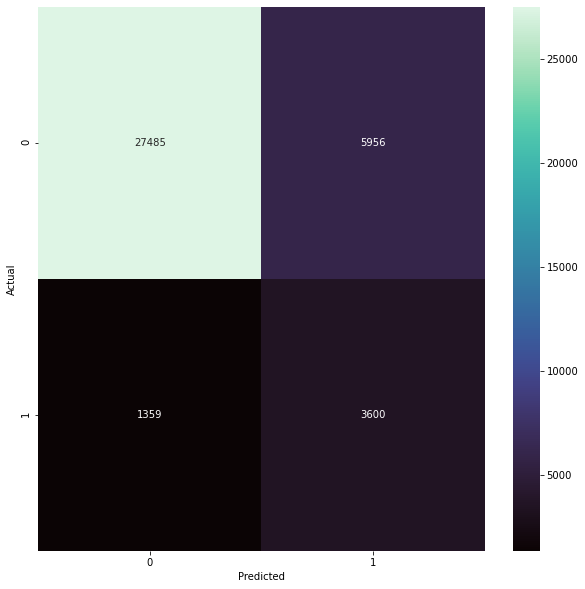

In [8]:
ex_results = ex_model.predict(ex_x_train)
plot_confusionmatrix(ex_results,ex_y_train, normalization = False)

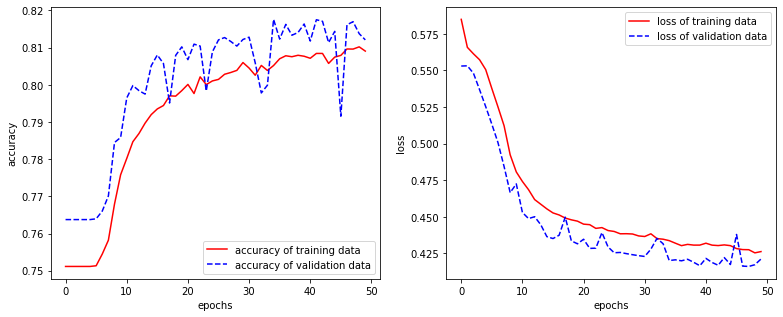

In [9]:
plot_accuracyloss(ex_fit, title = False)